# Convolutional AutoEncoder for Cifar dataset

## Backend and Import

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"]
print(kerasBKED)

tensorflow


In [ ]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation,Flatten,Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
import os
import pickle
import numpy as np

## Load Cifar10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [ ]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


## Convolutional AutoEncoder

In [ ]:
latentDim = 512
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(input_img, encoded, name="encoder")
 # flatten the network and then construct our latent vector
#volumeSize = K.int_shape(encoded)
volumeSize = encoded.shape
x = Flatten()(encoded)
latent = Dense(latentDim)(x)
encoder = Model(input_img, latent, name="encoder")
print("Volume Size: ", volumeSize)
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs) #Flatten
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)  # becomes like encoded 2D
x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)
decoder = Model(encoded, decoded, name="decoder")

Volume Size:  (None, 4, 4, 16)


In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,912 (612.94 KB)

 Trainable params: 156,688 (612.06 KB)

 Non-trainable params: 224 (896.00 B)

## Training the model

In [ ]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
#model.summary()

In [ ]:
batch_size = 512
#num_classes = 10
epochs = 20
saveDir = "/content/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.keras'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.6380
Epoch 1: val_loss improved from inf to 0.66666, saving model to /content/ae/AutoEncoder_Cifar10_Deep_weights.01-0.61-0.67.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - loss: 0.6377 - val_loss: 0.6667
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5910
Epoch 2: val_loss improved from 0.66666 to 0.64219, saving model to /content/ae/AutoEncoder_Cifar10_Deep_weights.02-0.59-0.64.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.5909 - val_loss: 0.6422
Epoch 3/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5845
Epoch 3: val_loss improved from 0.64219 to 0.61349, saving model to /content/ae/AutoEncoder_Cifar10_Deep_weights.03-0.58-0.61.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.5845 - val_loss: 0.6135
Epoch 4/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5811
Epoch 4: val_loss improved from 0.61349 to 0.59145, saving model to /content/ae/AutoEncoder_Cifar10_Deep_weights.04-0.

In [ ]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##Evaluate with test dataset

In [ ]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5697
0.5676265954971313


## Load from pretrained weights AutoEncoder

In [ ]:
# load pretrained weights
model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights.20-0.57-0.57.keras")

## Visualize original image and reconstructed image

In [ ]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.4822791814804077
Cifar10_val: 0.48564955592155457


In [ ]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

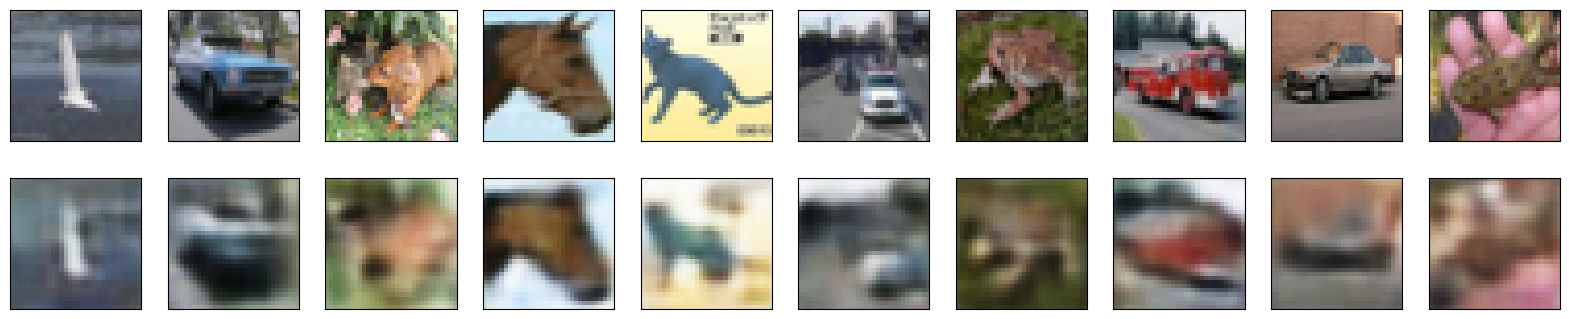

In [ ]:
showOrigDec(x_test, c10test)

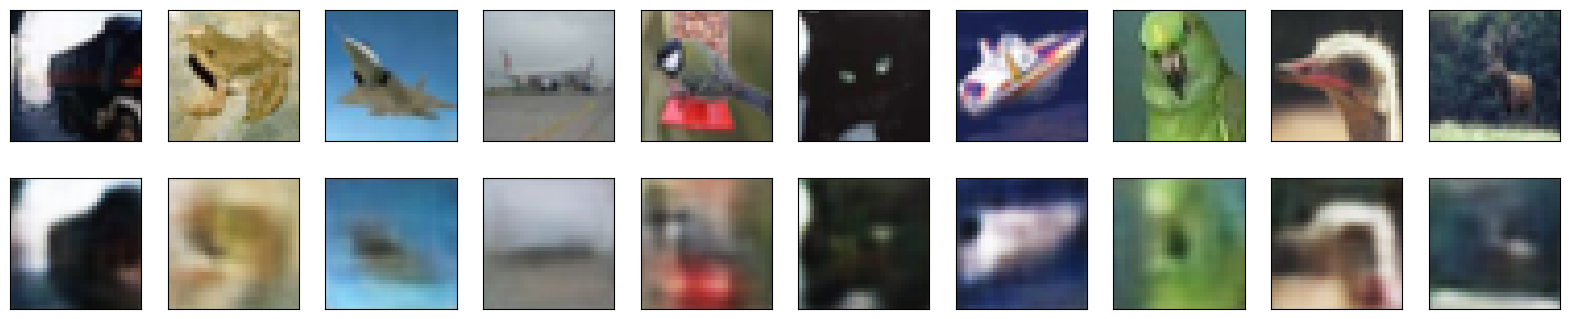

In [ ]:
showOrigDec(x_test[100:], c10test[100:])

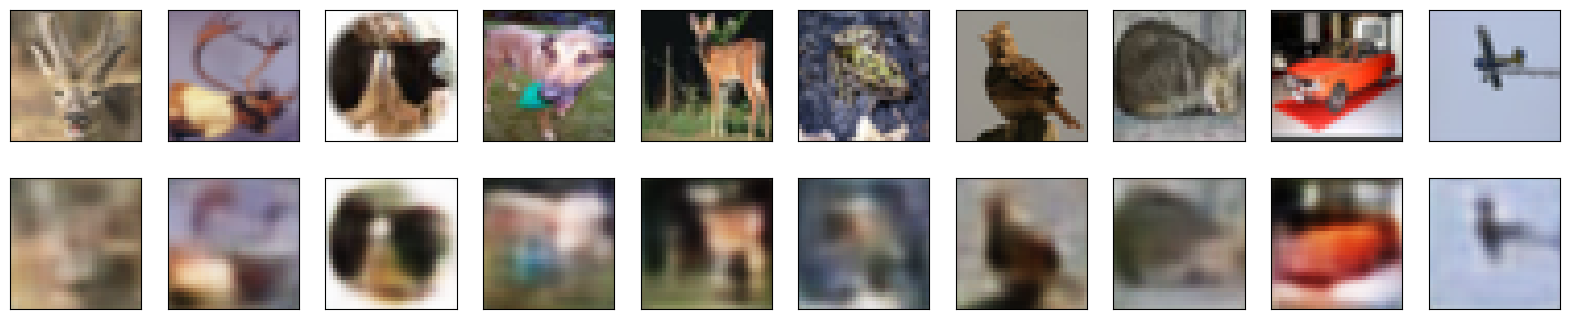

In [ ]:
showOrigDec(x_test[200:], c10test[200:])

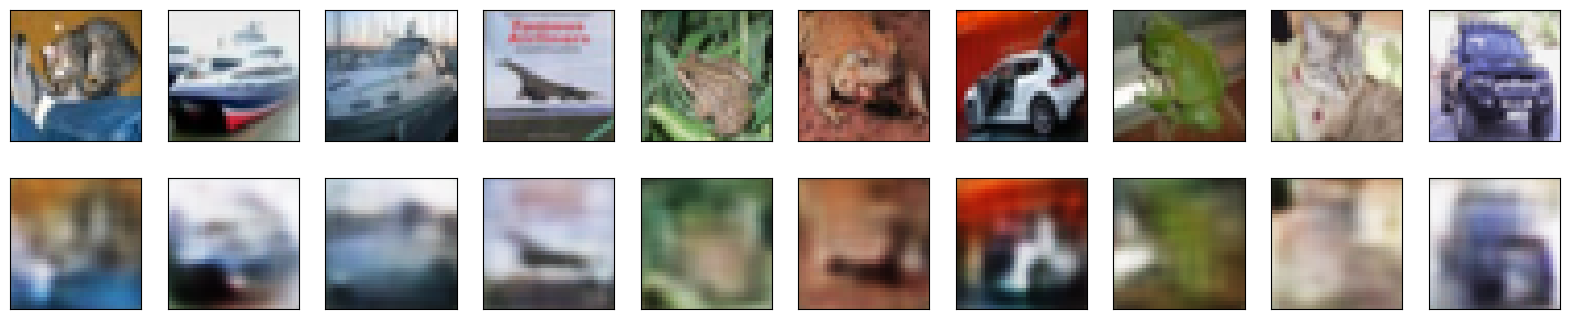

In [ ]:
showOrigDec(x_val, c10val)

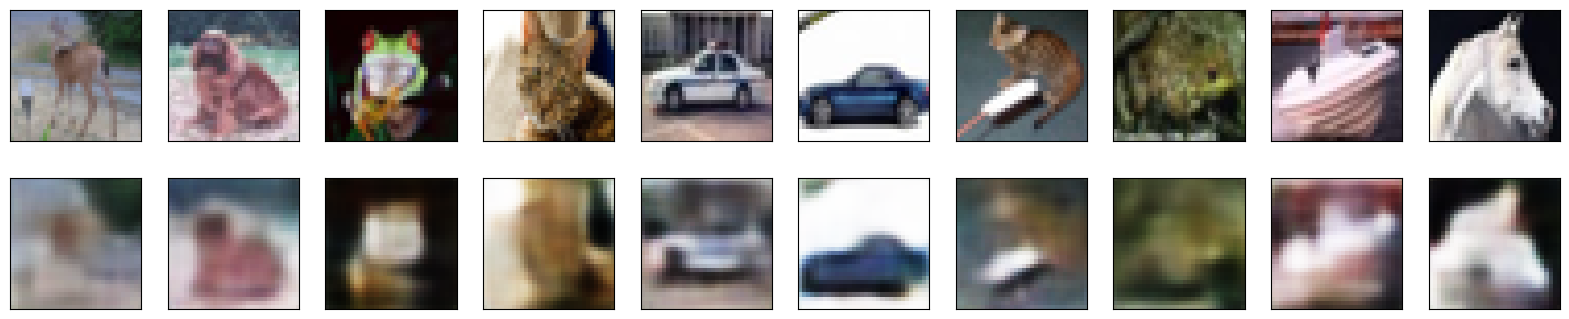

In [ ]:
showOrigDec(x_val[100:], c10val[100:])

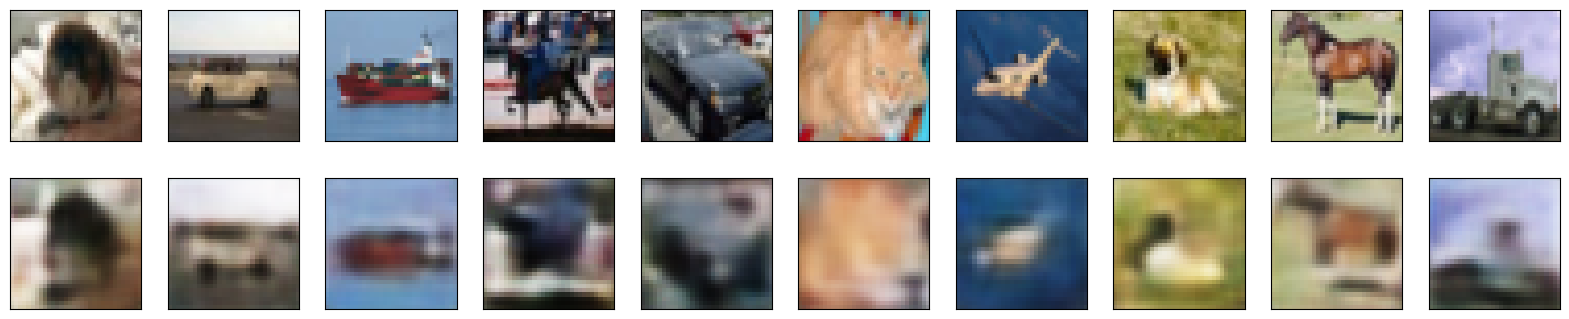

In [ ]:
showOrigDec(x_val[200:], c10val[200:])

## Try the Convolutional AutoEncoder on Cifar100

## Load cifar100 dataset

In [ ]:
from keras.datasets import cifar100

(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# normalize data
x_train100 = x_train100.astype('float32')
x_test100 = x_test100.astype('float32')
x_train100 /= 255
x_test100 /= 255

In [ ]:
print('x_train100 shape:', x_train100.shape)
print(x_train100.shape[0], 'train samples')
print(x_test100.shape[0], 'test samples')

x_train100 shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
score = model.evaluate(x_train100, x_train100, verbose=1)
print(score)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5459
0.5457228422164917


In [ ]:
score = model.evaluate(x_test100, x_test100, verbose=1)
print(score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5458
0.5450282096862793


## Autoencoder on Cifar100 dateset

In [ ]:
c100train = model.predict(x_train100)
c100test = model.predict(x_test100)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print("Cifar100 train: {0} \nCifar100 test: {1}"
      .format(np.average(c100train), np.average(c100test)))

Cifar100 train: 0.48629146814346313 
Cifar100 test: 0.48747411370277405


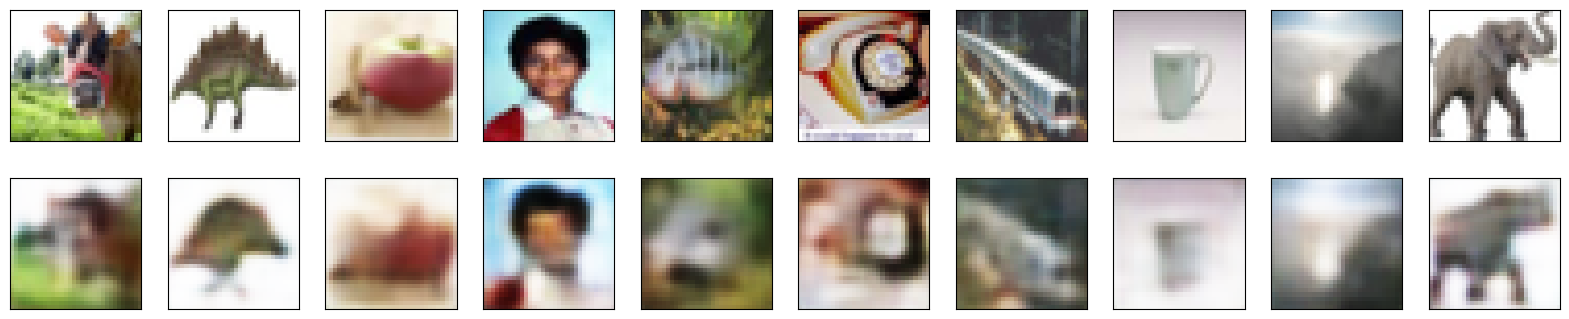

In [ ]:
showOrigDec(x_train100, c100train)

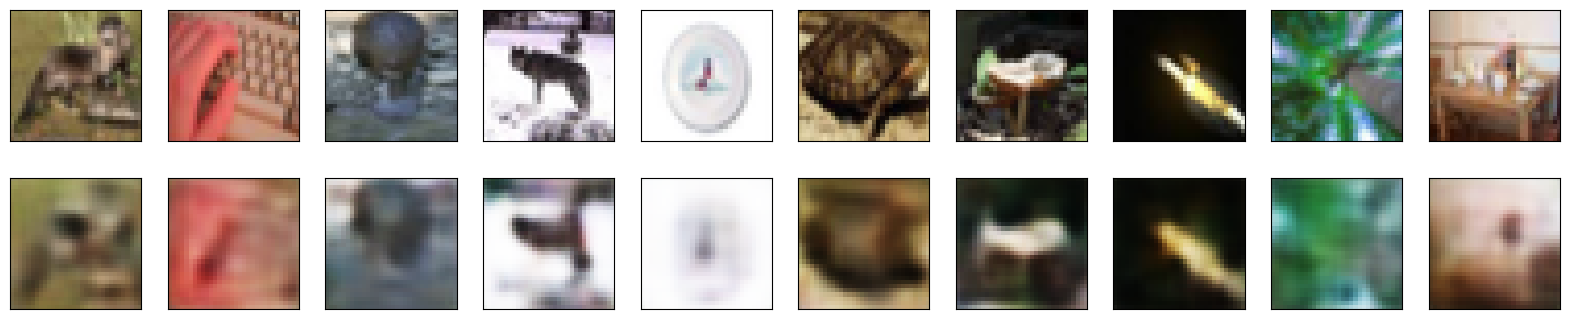

In [ ]:
showOrigDec(x_train100[100:], c100train[100:])

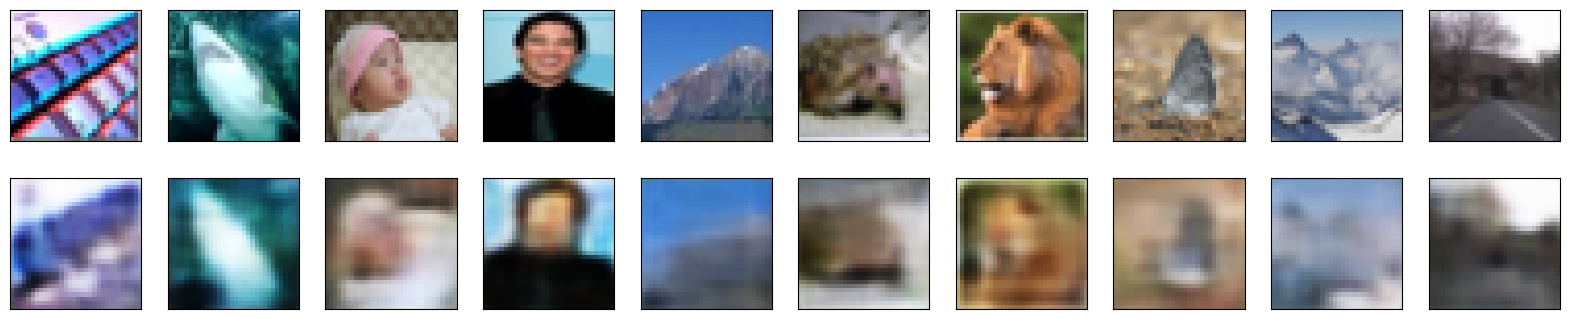

In [ ]:
showOrigDec(x_train100[200:], c100train[200:])

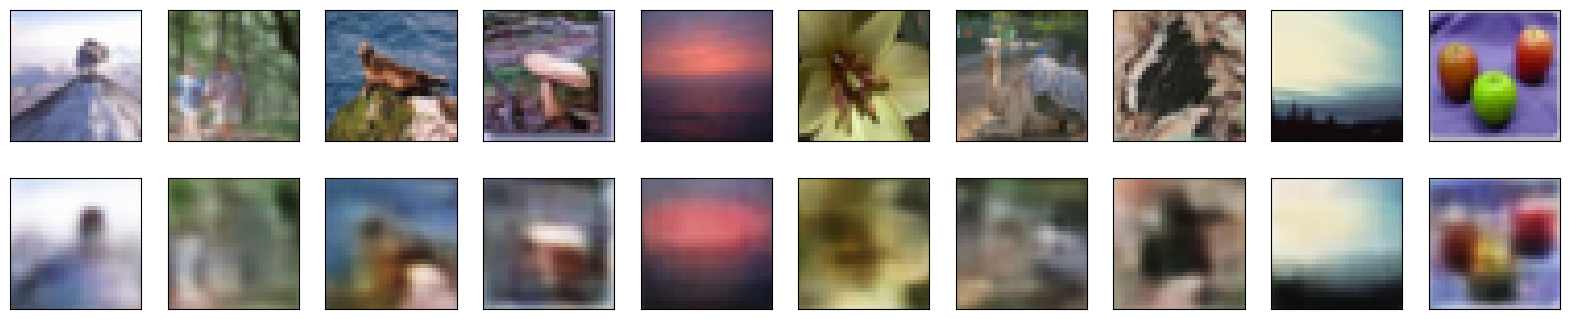

In [ ]:
showOrigDec(x_test100, c100test)

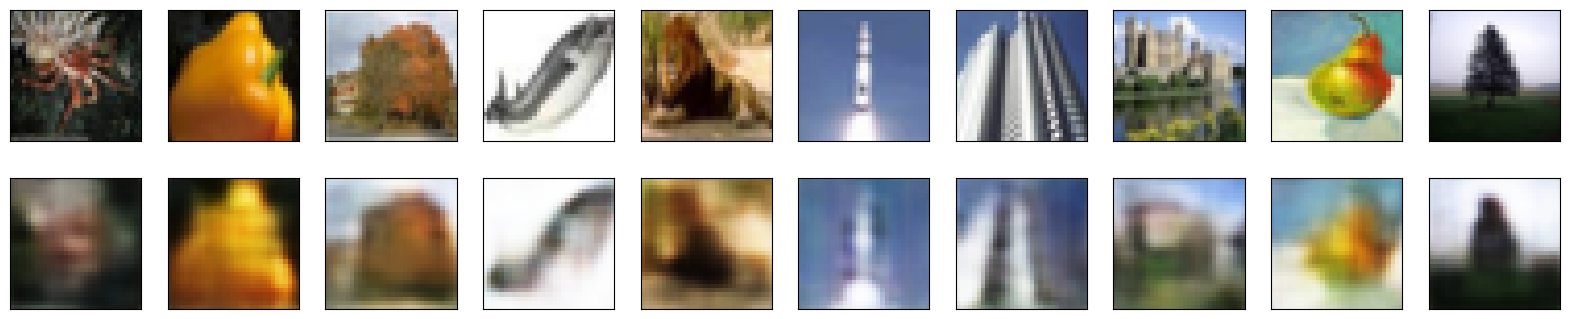

In [ ]:
showOrigDec(x_test100[100:], c100test[100:])

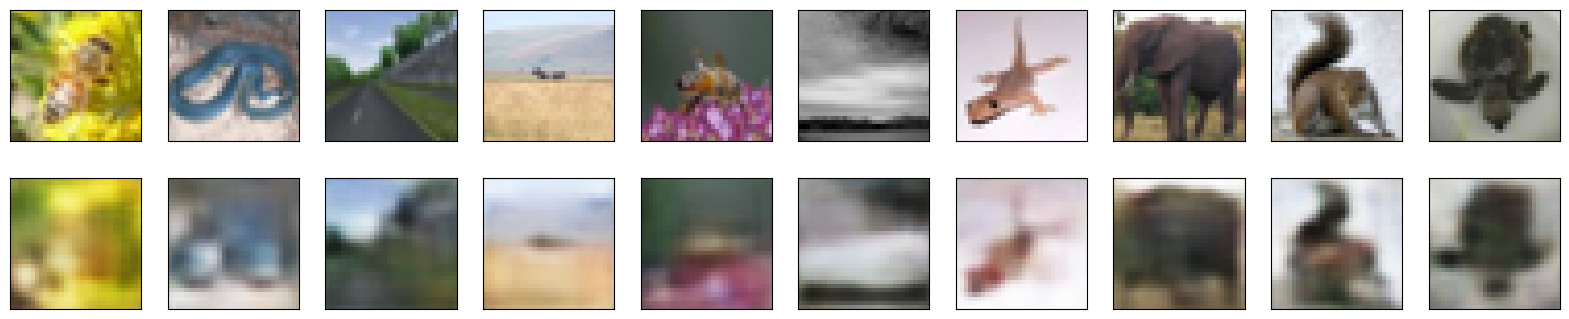

In [ ]:
showOrigDec(x_test100[200:], c100test[200:])

### Altering the hyperparameters

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D

input_img = Input(shape=(32, 32, 3), name="input_image")

# Encoder
x = Conv2D(64, (3, 3), padding="same")(input_img)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Latent Space
volume_size = x.shape[1:]
x = Flatten()(x)
latent = Dense(128, name="latent_space")(x)  # Compression size: 128
encoder = Model(input_img, latent, name="encoder")

# Decoder
latent_inputs = Input(shape=(128,), name="decoder_input")
x = Dense(np.prod(volume_size))(latent_inputs)
x = Reshape(volume_size)(x)

x = Conv2DTranspose(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid")(x)

# Autoencoder Model
decoder = Model(latent_inputs, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

# Compile Model
autoencoder.compile(optimizer="adam", loss="mse")


In [ ]:
import numpy as np
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

# Calculate average PSNR for all test images
psnr_values = [calculate_psnr(x_test[i], c10test[i]) for i in range(len(x_test))]
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Average PSNR: 21.508672879955604


In [ ]:
history = autoencoder.fit(
    x_train100, x_train100,
    validation_data=(x_test100, x_test100),
    epochs=50,
    batch_size=128,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    shuffle=True
)


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - loss: 0.0291 - val_loss: 0.0261
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0066 - val_loss: 0.0074
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━

In [ ]:
compression_rate = (3072 - 128 * 4) / 3072
print("Compression Rate:", compression_rate)

reconstructed_test = autoencoder.predict(x_test100)
psnr_values = [calculate_psnr(x_test100[i], reconstructed_test[i]) for i in range(len(x_test100))]
average_psnr = np.mean(psnr_values)
print("Average PSNR:", average_psnr)


Compression Rate: 0.8333333333333334
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Average PSNR: 23.646679767403533


### Final Conclusion

The notebook successfully demonstrates the design, training, and evaluation of a convolutional autoencoder for image compression on the CIFAR-100 dataset. The modified architecture achieves a high compression rate of 83.33% and an average PSNR of 23.65 dB, indicating a good balance between data reduction and reconstruction quality. The use of deeper convolutional layers, transposed convolutions, and a smaller latent space improved performance over the initial model. However, to approach practical deployment, further optimization of PSNR, inclusion of realistic compression overhead, and exploration of advanced architectures are recommended. This work provides a solid foundation for using autoencoders as a compression algorithm, with clear metrics to guide future improvements.